# Продуктовые метрики

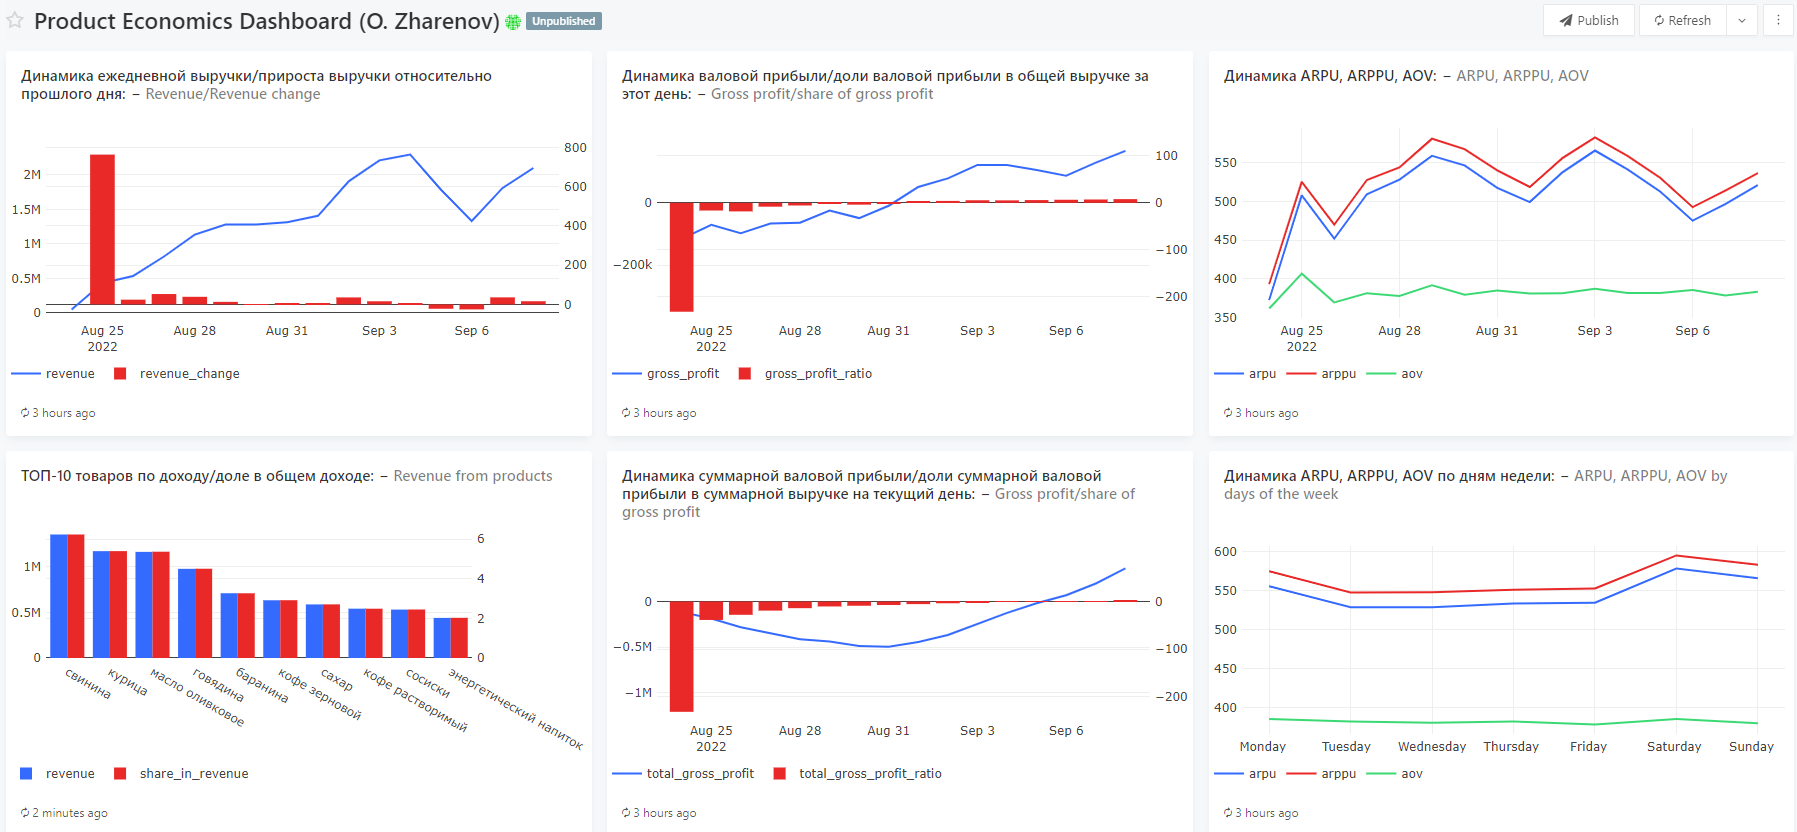

In [ ]:
"""
Для каждого дня рассчитаны следующие показатели:
Выручку, полученную в этот день.
Суммарную выручку на текущий день.
Прирост выручки, полученной в этот день, относительно значения выручки за предыдущий день.


select 
    date,
    revenue,
    SUM(revenue) OVER(order by date) as total_revenue,
    ROUND(100*revenue::decimal / LAG(revenue) OVER(order by date), 2) - 100 as revenue_change
from
(
    select 
        date, 
        SUM(price) as revenue
    from
    (
        select
            creation_time::date as date, 
            unnest(product_ids) as product_id
        from orders 
        where order_id not in (select order_id from user_actions where action = 'cancel_order')
    ) as o
    left join products on o.product_id = products.product_id
    group by date
) as result
"""

In [ ]:
"""
Для каждого дня расчитаны следующие показатели:
Выручку на пользователя (ARPU) за текущий день.
Выручку на платящего пользователя (ARPPU) за текущий день.
Выручку с заказа, или средний чек (AOV) за текущий день.


SELECT t1.date,
       round(revenue::decimal / active_user, 2) as arpu,
       round(revenue::decimal / paying_user, 2) as arppu,
       round(revenue::decimal / success_orders, 2) as aov
FROM   (SELECT date,
               count(distinct o.order_id) success_orders,
               count(distinct ua.user_id) paying_user,
               sum(price) as revenue
        FROM   (SELECT creation_time::date as date,
                       order_id,
                       unnest(product_ids) as product_id
                FROM   orders
                WHERE  order_id not in (SELECT order_id
                                        FROM   user_actions
                                        WHERE  action = 'cancel_order')) as o
            LEFT JOIN user_actions as ua
                ON o.order_id = ua.order_id
            LEFT JOIN products as p
                ON o.product_id = p.product_id
        GROUP BY date) as t1
    LEFT JOIN (SELECT time::date as date,
                      count(distinct user_id) as active_user
               FROM   user_actions
               GROUP BY date) as t2
        ON t1.date = t2.date
"""

In [ ]:
"""
Для каждого дня рассчитаны следующие показатели:
Накопленную выручку на пользователя (Running ARPU).
Накопленную выручку на платящего пользователя (Running ARPPU).
Накопленную выручку с заказа, или средний чек (Running AOV).


select
    t_po.date,
    round(SUM(revenue) OVER(order by t_po.date)::decimal / SUM(active_user) OVER(order by t_po.date), 2) as running_arpu,
    round(SUM(revenue) OVER(order by t_po.date)::decimal / SUM(paying_user) OVER(order by t_po.date), 2) as running_arppu,
    round(SUM(revenue) OVER(order by t_po.date)::decimal / SUM(success_orders) OVER(order by t_po.date), 2) as running_aov
from
(
    select
        o.date,
        count(distinct o.order_id) as success_orders,
        sum(price) as revenue
    from
    (
        select
            creation_time::date as date,
            unnest(product_ids) as product_id,
            order_id
        from orders
        where order_id not in (select order_id from user_actions where action = 'cancel_order')
    ) as o 
    left join products as p on o.product_id = p.product_id
    group by o.date
) as t_po
left join
(
    select
        date,
        count(user_id) as paying_user
    from
    (
        select
            min(time::date) as date,
            user_id
        from user_actions
        where order_id not in (select order_id from user_actions where action = 'cancel_order')
        group by user_id
    ) as t1
    group by date
) as t_pay_user
on t_po.date = t_pay_user.date
left join
(
    select
        date,
        count(user_id) as active_user
    from
    (
        select
            min(time::date) as date,
            user_id
        from user_actions
        group by user_id
    ) as t1
    group by date
) as t_active_user on t_pay_user.date = t_active_user.date
"""

In [ ]:
"""
ARPU, ARPPU, AOV в разрезе дней недели


select
    success_orders_and_revenue.weekday,
    success_orders_and_revenue.weekday_number,
    round(revenue / active_user, 2) as arpu,
    round(revenue / paying_user, 2) as arppu,
    round(revenue / success_orders, 2) as aov
from
(
    select
        weekday,
        weekday_number,
        count(distinct order_id) as success_orders,
        sum(price) as revenue
    from 
        (
            select
                order_id,
                to_char(creation_time::date, 'Day') as weekday,
                date_part('isodow', creation_time::date) as weekday_number,
                unnest(product_ids) as product_id
            from orders
            where creation_time::date between '2022-08-26' and '2022-09-08'
                and order_id not in (select order_id from user_actions where action = 'cancel_order')
        ) as o left join products as p on o.product_id = p.product_id
    group by weekday, weekday_number
) as success_orders_and_revenue
left join 
(
    select
        weekday,
        weekday_number,
        count(distinct user_id) as paying_user
    from
    (
        select
            to_char(time::date, 'Day') as weekday,
            min(date_part('isodow', time::date)) as weekday_number,
            user_id
        from user_actions
        where time::date between '2022-08-26' and '2022-09-08'
            and order_id not in (select order_id from user_actions where action = 'cancel_order')
        group by user_id, to_char(time::date, 'Day')
    ) as t1
    group by weekday, weekday_number
) as paying_users on success_orders_and_revenue.weekday = paying_users.weekday
left join
(
    select
        weekday,
        weekday_number,
        count(distinct user_id) as active_user
    from
    (
        select
            to_char(time::date, 'Day') as weekday,
            min(date_part('isodow', time::date)) as weekday_number,
            user_id
        from user_actions
        where time::date between '2022-08-26' and '2022-09-08'
        group by user_id, to_char(time::date, 'Day')
    ) as t1
    group by weekday, weekday_number
) as active_users on paying_users.weekday = active_users.weekday
order by success_orders_and_revenue.weekday_number
"""

In [ ]:
"""
Для каждого дня:
Выручка, полученная в этот день.
Выручка с заказов новых пользователей, полученная в этот день.
Доля выручки с заказов новых пользователей в общей выручке, полученной за этот день.
Доля выручки с заказов остальных пользователей в общей выручке, полученной за этот день.


select
    first_rev.date,
    revenue,
    new_users_revenue,
    round(100*new_users_revenue::decimal / revenue, 2) as new_users_revenue_share,
    100 - round(100*new_users_revenue::decimal / revenue, 2) as old_users_revenue_share
from
(
    select
        first_order.date,
        sum(price_order) as new_users_revenue
    from
    (
        select
            date,
            o.order_id,
            user_id,
            sum(price) as price_order
        from
        (
            select 
                creation_time::date as date,
                order_id,
                unnest(product_ids) as product_id
            from orders
            where order_id not in (select order_id from user_actions where action = 'cancel_order')
        ) as o
        left join products as p on o.product_id = p.product_id
        left join user_actions as ua on o.order_id = ua.order_id
        group by date, o.order_id, user_id
    ) as d_o_u_p
    join
    (
        select
            min(time::date) as date,
            user_id
        from user_actions
        group by user_id
    ) as first_order on d_o_u_p.date = first_order.date and d_o_u_p.user_id = first_order.user_id
    group by first_order.date
) as first_rev
left join
(
    select
        date,
        sum(price) as revenue
    from
    (
        select 
            creation_time::date as date,
            order_id,
            unnest(product_ids) as product_id
        from orders
        where order_id not in (select order_id from user_actions where action = 'cancel_order')
    ) as o1 
    left join products as p1 on o1.product_id = p1.product_id
    group by date
) as total_revenue on first_rev.date = total_revenue.date
order by first_rev.date
"""

In [ ]:
"""
ТОП-10 товаров по выручке


select
    product_name,
    SUM(revenue) as revenue,
    SUM(share_in_revenue) as share_in_revenue
from
(
    select
        case
            when share_in_revenue < 0.5 THEN 'ДРУГОЕ'
            else name
        end as product_name,
        revenue,
        share_in_revenue
    from
    (
        select
            name,
            revenue as revenue,
            round(100*revenue::decimal / (SUM(revenue) OVER()), 2) as share_in_revenue
        from
        (
            select
                o.product_id,
                name,
                sum(price) as revenue
            from
            (
                select
                    unnest(product_ids) as product_id
                from orders
                where order_id not in (select order_id from user_actions where action = 'cancel_order')
            ) as o
            left join products on o.product_id = products.product_id
            group by o.product_id, name
        ) as t1
        order by share_in_revenue desc
    ) as t2
) as t3
where product_name != 'ДРУГОЕ'
group by product_name
order by revenue desc
limit 10
"""

In [ ]:
"""
Выручка, полученная в этот день.
Затраты, образовавшиеся в этот день.
Сумма НДС с продажи товаров в этот день.
Валовая прибыль в этот день (выручка за вычетом затрат и НДС).
Суммарная выручку на текущий день.
Суммарные затраты на текущий день.
Суммарный НДС на текущий день.
Суммарная валовую прибыль на текущий день.
Доля валовой прибыли в выручке за этот день (долю п.4 в п.1).
Доля суммарной валовой прибыли в суммарной выручке на текущий день (долю п.8 в п.5).


select
    table_revenue.date as date,
    revenue,
    costs::int,
    round(tax, 2) as tax,
    round(revenue - costs - tax, 2) as gross_profit,
    sum(revenue) over(order by table_revenue.date) total_revenue,
    sum(costs) over(order by table_revenue.date) total_costs, 
    round(sum(tax) over(order by table_revenue.date), 2) total_tax, 
    sum(revenue - costs - tax) over(order by table_revenue.date) total_gross_profit,
    round(100*(revenue - costs - tax)::decimal / revenue, 2) as gross_profit_ratio,
    round(100*(sum(revenue - costs - tax) over(order by table_revenue.date))::decimal / sum(revenue) over(order by table_revenue.date), 2) as total_gross_profit_ratio
from
(
    select
        date,
        sum(price) as revenue
    from
    (
        select
            creation_time::date as date,
            unnest(product_ids) as product_id
        from orders
        where order_id not in (select order_id from user_actions where action = 'cancel_order')
    ) as t3 left join products on t3.product_id = products.product_id
    group by date
) as table_revenue    
left join
(
    select 
        date,
        case
            when date_part('month', date) = 8 then 120000 + sum(delived_orders)*150 + sum(accept_order)*140 + 400*count(courier_id) FILTER(where delived_orders >= 5)
            when date_part('month', date) = 9 then 150000 + sum(delived_orders)*150 + sum(accept_order)*115 + 500*count(courier_id) FILTER(where delived_orders >= 5)
        end as costs
    from
    (
        select 
            time::date as date,
            count(distinct order_id) FILTER(where action = 'deliver_order') delived_orders,
            count(distinct order_id) FILTER(where action = 'accept_order') accept_order,
            courier_id
        from courier_actions
        where order_id not in (select order_id from user_actions where action = 'cancel_order')
        group by date, courier_id
    ) as t2
    group by date
) as table_cost on table_revenue.date = table_cost.date
left join 
(
    select
        date,
        sum(case
            when name in ('сахар', 'сухарики', 'сушки', 'семечки', 'масло льняное', 'виноград', 'масло оливковое', 'арбуз', 'батон', 'йогурт', 'сливки', 
            'гречка','овсянка', 'макароны', 'баранина', 'апельсины', 'бублики', 'хлеб', 'горох', 'сметана', 'рыба копченая', 'мука', 'шпроты', 'сосиски', 
            'свинина', 'рис', 'масло кунжутное', 'сгущенка', 'ананас', 'говядина', 'соль', 'рыба вяленая', 'масло подсолнечное', 'яблоки', 'груши', 'лепешка', 
            'молоко', 'курица', 'лаваш', 'вафли', 'мандарины') then round(price::decimal * 0.1 / 1.1, 2)
        else round(price::decimal * 0.20 / 1.2 , 2) 
        end) as tax
    from
    (
        select
            creation_time::date as date,
            unnest(product_ids) as product_id
        from orders
        where order_id not in (select order_id from user_actions where action = 'cancel_order')
    ) as t1 
    left join products on t1.product_id = products.product_id
    group by date
) as table_tax on table_revenue.date = table_tax.date
"""